## Annexe

#### 1. Function to analyze descriptive statistics for a given country

In [73]:
def describe_country(data, country=None):
    """
    Describe the country data.

    Parameters:
    data (pd.DataFrame): The data to describe.
    country (str, optional): The country to filter by. Defaults to None.

    Returns:
    tuple: A tuple containing the number of rows, unique collections, top collection, unique references, top reference, and a list of unique collections.
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Create a summary of the object columns if needed
    summary = data.describe(include="object")
    
    # Extract required details directly from the original data
    number_rows = data.shape[0]
    number_unique_collections = data['collection'].nunique()
    top_collection = data['collection'].mode()[0]
    
    number_unique_references = data['reference'].nunique()
    top_reference = data['reference'].mode()[0]
    
    collection_list = data['collection'].unique()
    
    return number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list


#### 2. Visualization

In [74]:
def collection_visualization(data, country=None):
    """
    Visualize the collection data.

    Parameters:
    data (pd.DataFrame): The data to visualize.
    country (str): The country to filter by.

    Returns:
    None
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Choose a color palette
    palette = sns.color_palette("pastel")  # You can choose different palettes like "deep", "pastel", etc.

    # Create the count plot
    ax = sns.countplot(x="collection", data=data, palette=palette)

    # Add the count value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Labels and title
    plt.xlabel("Collection")
    plt.ylabel("Watch Count")
    plt.title(f"Watch Count per Collection in {country}")

    # Show the plot
    plt.show()

#### 3. Function to analyze the cheapest and most expensive products for a given country

In [75]:
def analyze_country(data, country=None):
    """
    Analyze the country data.

    Parameters:
    data (pd.DataFrame): The data to analyze.
    country (str, optional): The country to filter by. Defaults to None.

    Returns:
    tuple: A tuple containing the overall statistics and the collection statistics.
    """
    # Filter the original data if a specific country is provided
    if country:
        data = data[data["country"] == country]
    
    # Identify the cheapest and most expensive product in the whole subset
    cheapest_product_data = data.nsmallest(1, 'price')
    most_expensive_product_data = data.nlargest(1, 'price')
    
    overall_stats = {
        "cheapest": {
            "collection": cheapest_product_data['collection'].values[0],
            "reference": cheapest_product_data['reference'].values[0],
            "price": cheapest_product_data['price'].values[0]
        },
        "most_expensive": {
            "collection": most_expensive_product_data['collection'].values[0],
            "reference": most_expensive_product_data['reference'].values[0],
            "price": most_expensive_product_data['price'].values[0]
        }
    }
    
    # Identify the cheapest and most expensive product per collection
    collection_stats = []
    unique_collections = data["collection"].unique()
    
    for collection in unique_collections:
        collection_data = data[data["collection"] == collection]
        
        cheapest_collection_data = collection_data.nsmallest(1, 'price')
        most_expensive_collection_data = collection_data.nlargest(1, 'price')
        
        collection_stats.append({
            "collection": collection,
            "cheapest": {
                "reference": cheapest_collection_data['reference'].values[0],
                "price": cheapest_collection_data['price'].values[0]
            },
            "most_expensive": {
                "reference": most_expensive_collection_data['reference'].values[0],
                "price": most_expensive_collection_data['price'].values[0]
            }
        })
    
    return overall_stats, collection_stats

#### 4. Compute the difference of watch's price from this minimum

In [76]:
def calculate_price_difference(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), calculates the minimum price across all countries,
    computes the difference of each record's price from this minimum, and identifies the country that offers
    the minimum price.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns:
            - 'name': Product name.
            - 'country': Country of the product.
            - 'product_url': URL for the product.
            - 'collection'
            - 'reference'
            - 'price_USD'
    
    Returns:
        pd.DataFrame: The input DataFrame with additional columns:
                      - 'min_price': The minimum price for each product.
                      - 'price_diff': The difference between the price and the minimum price.
                      - 'min_price_country': The country corresponding to the minimum price.
                      The resulting DataFrame is re-ordered to include 'name', 'country', 'min_price_country', and 'product_url'.
    """
    df = data.copy()
    group_cols = ['collection', 'reference']
    
    # Calculate the minimum price for each product group
    df['min_price'] = df.groupby(group_cols)['price_USD'].transform('min')
    
    # Calculate the price difference from the minimum price
    df['price_diff'] = df['price_USD'] - df['min_price']
    
    # Determine the country corresponding to the minimum price for each group.
    # This finds the index of the minimum price for each group and extracts the country.
    min_price_country_df = df.loc[df.groupby(group_cols)['price_USD'].idxmin(), group_cols + ['country']]
    min_price_country_df = min_price_country_df.rename(columns={'country': 'min_price_country'})
    
    # Merge the min_price_country back into the main DataFrame using the group columns as key.
    df = df.merge(min_price_country_df, on=group_cols, how='left')
    
    # Reorder columns for clarity in the CSV output.
    desired_columns = ['name', 'country', 'min_price_country', 'product_url', 'collection', 'reference', 'price_USD', 'min_price', 'price_diff']
    available_columns = [col for col in desired_columns if col in df.columns]
    df = df[available_columns]
    
    # Save the result to a CSV file.
    df.to_csv('price_difference.csv', index=False)
    
    return df

#### 5. Identify the cheapest price and its corresponding country

In [77]:
def find_cheapest_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), identifies the cheapest price and its corresponding country.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns 'collection', 'reference', 'price_USD', and 'country'.
    
    Returns:
        pd.DataFrame: A DataFrame containing:
                      - 'collection'
                      - 'reference'
                      - 'cheapest_price': The lowest price found for the product.
                      - 'cheapest_country': The country corresponding to the cheapest price.
    """
    group_cols = ['collection', 'reference']
    cheapest = data.loc[data.groupby(group_cols)['min_price'].idxmin()].copy()
    cheapest = cheapest[['collection', 'reference', 'price_USD', 'country']]
    cheapest.rename(columns={'price_USD': 'cheapest_price', 'country': 'cheapest_country'}, inplace=True)
    cheapest.to_csv('cheapest_prices.csv', index=False)
    
    return cheapest

#### 6. Identify the best selling options

In [78]:
def find_best_sell_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    For each product (grouped by collection and reference), identifies the best selling option,
    defined as the country where the product has the highest price. Also calculates potential profit
    by finding the difference between the best selling price and the minimum price.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with columns:
            - 'collection'
            - 'reference'
            - 'price_USD'
            - 'country'

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'collection'
            - 'reference'
            - 'best_sell_price': The highest price found for the product.
            - 'best_sell_country': The country corresponding to the highest price.
            - 'min_price': The minimum price for the product.
            - 'min_price_country': The country where the minimum price is found.
            - 'profit': The potential profit from buying at the cheapest price and selling at the highest price.
    """
    group_cols = ['collection', 'reference']

    # Find the best selling price (highest price) and the country
    best_sell = data.loc[data.groupby(group_cols)['price_USD'].idxmax()].copy()
    best_sell = best_sell[['collection', 'reference', 'price_USD', 'country']]
    best_sell.rename(columns={'price_USD': 'best_sell_price', 'country': 'best_sell_country'}, inplace=True)

    # Find the minimum price and its country
    min_price = data.loc[data.groupby(group_cols)['price_USD'].idxmin()].copy()
    min_price = min_price[['collection', 'reference', 'price_USD', 'country']]
    min_price.rename(columns={'price_USD': 'min_price', 'country': 'min_price_country'}, inplace=True)

    # Merge both DataFrames to have best selling and minimum price information in one table
    result = pd.merge(best_sell, min_price, on=['collection', 'reference'], how='left')

    # Calculate potential profit
    result['profit'] = result['best_sell_price'] - result['min_price']

    # Save the results
    result.to_csv('best_sell_prices_with_profit.csv', index=False)
    
    return result

#### 7. The sum of potential profits per collection

In [79]:
def sum_profit(data: pd.DataFrame):
    """
    Computes the sum of potential profits per collection.

    Parameters:
        data (pd.DataFrame): DataFrame with best sell prices and profit computed.

    Returns:
        Dictionary of DataFrames:
            - 'profit_by_reference': Profit summed per country based on product reference.
            - 'profit_by_collection': Profit summed per country based on collection.
    """
    
    # Aggregate total profit per country (based on reference)
    global_profit = data['profit'].sum()

    # Aggregate total profit per country (based on collection)
    profit_by_collection = data.groupby('collection', as_index=False)['profit'].sum()
    profit_by_collection.rename(columns={'profit': 'total_profit_by_collection ($)'}, inplace=True)

    return {
        "global_profit": global_profit,
        "profit_by_collection": profit_by_collection
    }

In [80]:
EXCHANGE_API_KEY = "1469e13710f523e45c568282"

def get_exchange_rate(from_currency: str, to_currency: str) -> float:
    """
    Fetches real-time exchange rates using ExchangeRate-API.
    
    Args:
        from_currency (str): Base currency (e.g., 'USD').
        to_currency (str): Target currency (e.g., 'EUR').

    Returns:
        float: Exchange rate from 'from_currency' to 'to_currency', or None if an error occurs.
    """
    if from_currency.upper() == to_currency.upper():
        return 1.0

    url = f"https://v6.exchangerate-api.com/v6/{EXCHANGE_API_KEY}/latest/{from_currency.upper()}"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        if "conversion_rates" not in data:
            raise ValueError("Invalid API response: missing 'conversion_rates'")

        rate = data["conversion_rates"].get(to_currency.upper())
        if rate is None:
            raise ValueError(f"Exchange rate for {to_currency.upper()} not found in API response")

        return rate

    except requests.exceptions.RequestException as e:
        log_error(f"Network error: {e}")
    except ValueError as e:
        log_error(f"Data error: {e}")
    except Exception as e:
        log_error(f"Unexpected error: {e}")

    return None  # Return None in case of an error

https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/USD


0.9628

In [186]:
# Currency code mapping
def currency_convertor(df):
    
    data = df.copy()
    
    try:
        valid_currencies = set(data['currency'])
        # Extract unique source currencies that are valid
        unique_source_currencies = data.loc[data['currency'].isin(valid_currencies), 'currency'].unique()

        # Precompute exchange rates for each (source, target) pair
        exchange_rates = {}
        for source_currency in unique_source_currencies:
            for target_currency in valid_currencies:
                rate = get_exchange_rate(source_currency, target_currency)
                exchange_rates[(source_currency, target_currency)] = rate

        # For each target currency, build a mapping from source currency to exchange rate
        for target_currency in valid_currencies:
            col_name = f"price_{target_currency}"
            rate_mapping = {
                source: exchange_rates[(source, target_currency)]
                for source in unique_source_currencies
                if exchange_rates[(source, target_currency)] is not None
            }
            # Use vectorized mapping to apply the conversion
            data[col_name] = data['price'] * data['currency'].map(rate_mapping)
    except Exception as e:
        print(e)
    
    return data

# 1. Import librariries

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

# 2. Load & Read the Data

In [189]:
data = pd.read_csv(r"../data/bronze/PANERAI_DATA_2021.csv")
data.head()

,brand,url,image_url,collection,reference,price,currency,country,time scope
0,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/10...,RADIOMIR,PAM00655,9700.0,EUR,France,December 2021
1,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00628,11600.0,EUR,France,December 2021
2,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00657,11400.0,EUR,France,December 2021
3,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM00661,11900.0,EUR,France,December 2021
4,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM01312,7900.0,EUR,France,December 2021


# 3. Exploratory Data Analysis (EDA)

### 3.1. Columns list

In [190]:
column_list = list(data.columns)

print("List of column name:\n")
for i in range(len(column_list)):
    print(f"\t{i+1}. {column_list[i]}")

List of column name:

	1. brand
	2. url
	3. image_url
	4. collection
	5. reference
	6. price
	7. currency
	8. country
	9. time scope


### 3.2. Data types discovery

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   brand       693 non-null    object 
 1   url         693 non-null    object 
 2   image_url   690 non-null    object 
 3   collection  693 non-null    object 
 4   reference   693 non-null    object 
 5   price       687 non-null    float64
 6   currency    693 non-null    object 
 7   country     693 non-null    object 
 8   time scope  693 non-null    object 
dtypes: float64(1), object(8)
memory usage: 48.9+ KB


--------------------------------------------------------------------------------------

**The dataset we used in the following use case contains**:

    1. 693 row of data
    
    2. 8 categoircal columns
    
    3. 1 numerical column
--------------------------------------------------------------------------------------

### 3.3. Check Missing Values

In [192]:
data.isna().sum()

brand         0
url           0
image_url     3
collection    0
reference     0
price         6
currency      0
country       0
time scope    0
dtype: int64

--------------------------------------------------------------------------------------

**The dataset contains some missing values**:

    - 3 in **image_url** column
    
    - 6 in **price** column
--------------------------------------------------------------------------------------

In [193]:
#### 3.3. Handling missing values

In [194]:
data.dropna(subset=['reference', 'price'], inplace=True)

In [195]:
data.isna().sum()

brand         0
url           0
image_url     3
collection    0
reference     0
price         0
currency      0
country       0
time scope    0
dtype: int64

--------------------------------------------------------------------------------------

**Now, the dataset is clean, no more missing values**

    ** -> We are ready to GO **

--------------------------------------------------------------------------------------

### 3.4. Check for duplicates bases on 'reference' and 'country'

In [196]:
# Check for duplicates based on 'reference', 'country', and 'collection'
duplicates = data.duplicated(subset=['reference', 'country']).sum()

# Display the duplicate rows
print(duplicates)

0


### 3.5. Descriptive statistics

In [197]:
stats = data.describe(include="object")
stats

,brand,url,image_url,collection,reference,currency,country,time scope
count,687,687,684,687,687,687,687,687
unique,1,687,206,4,207,4,4,1
top,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/10...,LUMINOR,PAM00655,JPY,Japan,December 2021
freq,687,1,4,368,4,201,201,687


In [198]:
# Now use the function on your original data
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data)

print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    # Use the original data for lookup, not the summary!
    collection_for_top_reference = data[data['reference'] == top_reference]['collection'].iloc[0]
    print(f"\nWe have a total of {number_unique_references} distinct products, with {top_reference} leading the selection from the {collection_for_top_reference} collection")


Number of rows: 687

We have 4 collections, and LUMINOR is the leading one

Catalog of Collections:
1. RADIOMIR
2. LUMINOR
3. SUBMERSIBLE
4. LUMINOR-DUE

We have a total of 207 distinct products, with PAM00233 leading the selection from the LUMINOR collection


In [199]:
# Brand
number_unique_brands, top_brand = stats["brand"].unique()[1], stats["brand"].unique()[2]
if number_unique_brands == 1:
    print(f"There is a unique brand, named {top_brand}")
else:
    print(f"There is {number_unique_brands} brands, and {top_brand} is the leading one")

There is a unique brand, named Panerai


In [200]:
# Countries
number_unique_countries, top_country = stats["country"].unique()[1], stats["country"].unique()[2]
if number_unique_countries == 1:
    print(f"Our study is applied to a unique country, {top_country}")
else:
    print(f"Our study is applied to {number_unique_countries} countries, with {top_country} being the top one")

Our study is applied to 4 countries, with Japan being the top one


In [201]:
countries_list = data["country"].unique()

print("Countries Included in the Study:\n")
for i in range(len(countries_list)):
    print(f"\t{i+1}. {countries_list[i]}")

Countries Included in the Study:

	1. France
	2. UK
	3. Japan
	4. USA


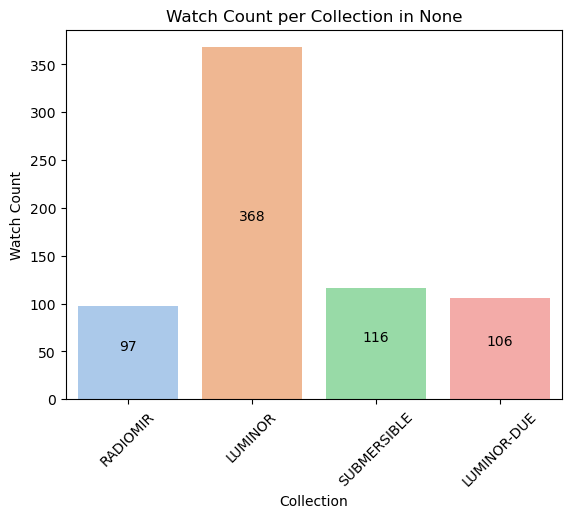

In [202]:
collection_visualization(data)

In [203]:
data.head()

,brand,url,image_url,collection,reference,price,currency,country,time scope
0,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/10...,RADIOMIR,PAM00655,9700.0,EUR,France,December 2021
1,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00628,11600.0,EUR,France,December 2021
2,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00657,11400.0,EUR,France,December 2021
3,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM00661,11900.0,EUR,France,December 2021
4,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM01312,7900.0,EUR,France,December 2021


## 4. Data Preprocessing

In [204]:
data["year"] = data["time scope"].str.split(' ', expand=True)[1]
data["year"] = pd.to_numeric(data['year'], errors='coerce')
data.drop("time scope", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687 entries, 0 to 692
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   brand       687 non-null    object 
 1   url         687 non-null    object 
 2   image_url   684 non-null    object 
 3   collection  687 non-null    object 
 4   reference   687 non-null    object 
 5   price       687 non-null    float64
 6   currency    687 non-null    object 
 7   country     687 non-null    object 
 8   year        687 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 53.7+ KB


In [184]:
data = currency_convertor(data)

https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/EUR
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/EUR
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/EUR
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/GBP
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/GBP
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/GBP
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/JPY
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/JPY
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/JPY
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/USD
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/USD
https://v6.exchangerate-api.com/v6/1469e13710f523e45c568282/latest/USD


In [208]:
data.head()

,brand,url,image_url,collection,reference,price,currency,country,year,price_EUR,price_GBP,price_USD,price_JPY
0,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/10...,RADIOMIR,PAM00655,9700.0,EUR,France,2021,9700.0,8009.29,10074.42,1516928.68
1,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00628,11600.0,EUR,France,2021,11600.0,9578.12,12047.76,1814059.04
2,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/11...,RADIOMIR,PAM00657,11400.0,EUR,France,2021,11400.0,9412.98,11840.04,1782782.16
3,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM00661,11900.0,EUR,France,2021,11900.0,9825.83,12359.34,1860974.36
4,Panerai,https://www.panerai.com/fr/fr/collections/watc...,https://www.panerai.com/content/dam/rcq/pan/13...,LUMINOR,PAM01312,7900.0,EUR,France,2021,7900.0,6523.03,8204.94,1235436.76


In [209]:
data.to_csv("../data/silver/PANERAI_DATA_2021.csv", index=False)

## 4. Business Analysis

## 4.1. Analysis of the global data

#### 4.1.1. Top products with the highest price difference (difference from the minimum price)

In [210]:
data_with_diff = calculate_price_difference(data)

print("Top 5 products with the highest price difference:")
# Group by product and pick the row with the maximum price difference per product
top_diff = data_with_diff.sort_values('price_diff', ascending=False).drop_duplicates(subset=['collection', 'reference'])
top_diff.head()

Top 5 products with the highest price difference:


,country,min_price_country,collection,reference,price_USD,min_price,price_diff
641,USA,Japan,LUMINOR,PAM01060,217000.0,137548.392,79451.608
581,USA,Japan,LUMINOR,PAM00768,189000.0,119730.589,69269.411
605,USA,France,SUBMERSIBLE,PAM01108,247700.0,197334.000,50366.000
639,USA,Japan,LUMINOR,PAM00715,85900.0,54569.097,31330.903
638,USA,Japan,SUBMERSIBLE,PAM01225,78300.0,49528.578,28771.422


#### 4.1.2. The Product Offered by the Country with the Cheapest Price

In [211]:
cheapest_prices = find_cheapest_prices(data_with_diff)

print("\nCheapest prices per product:")
print(cheapest_prices.head())


Cheapest prices per product:
    collection reference  cheapest_price cheapest_country
139    LUMINOR  PAM00233       12463.200           France
479    LUMINOR  PAM00317       17386.138            Japan
132    LUMINOR  PAM00335       17967.780           France
480    LUMINOR  PAM00372        7232.049            Japan
140    LUMINOR  PAM00422       10178.280           France


#### 4.1.3. The best selling option

In [212]:
best_sell_prices = find_best_sell_prices(data)

print("\nBest selling prices by product (sample):")
best_sell_prices.head(5)


Best selling prices by product (sample):


,collection,reference,best_sell_price,best_sell_country,min_price,min_price_country,profit
0,LUMINOR,PAM00233,15600.000,USA,10007.987,Japan,5592.013
1,LUMINOR,PAM00317,27200.000,USA,17386.138,Japan,9813.862
2,LUMINOR,PAM00335,19016.940,UK,14317.996,Japan,4698.944
3,LUMINOR,PAM00372,7232.049,Japan,7232.049,Japan,0.000
4,LUMINOR,PAM00422,12800.000,USA,8108.661,Japan,4691.339


#### 4.1.4. The sum of potential profits per collection

In [213]:
# Run the function
profits = sum_profit(best_sell_prices)

# Print the results
print(f"Total Profit: {profits['global_profit']} $")

print("\nProfit by Collection:")
print(profits["profit_by_collection"])


Total Profit: 1310497.1365 $

Profit by Collection:
    collection  total_profit_by_collection ($)
0      LUMINOR                     711004.3975
1  LUMINOR-DUE                     128319.1320
2     RADIOMIR                     139832.3740
3  SUBMERSIBLE                     331341.2330


## 4.2. Analysis for a given country

### 4.2.1. France

In [214]:
country = "France"

In [215]:
# Now use the function on your original data
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country = "France")

print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    # Use the original data for lookup, not the summary!
    collection_for_top_reference = data[data['reference'] == top_reference]['collection'].iloc[0]
    print(f"\nWe have a total of {number_unique_references} distinct products, with {top_reference} leading the selection from the {collection_for_top_reference} collection")


Number of rows: 153

We have 4 collections, and LUMINOR is the leading one

Catalog of Collections:
1. RADIOMIR
2. LUMINOR
3. SUBMERSIBLE
4. LUMINOR-DUE

We have a total of 153 distinct products, with PAM00233 leading the selection from the LUMINOR collection


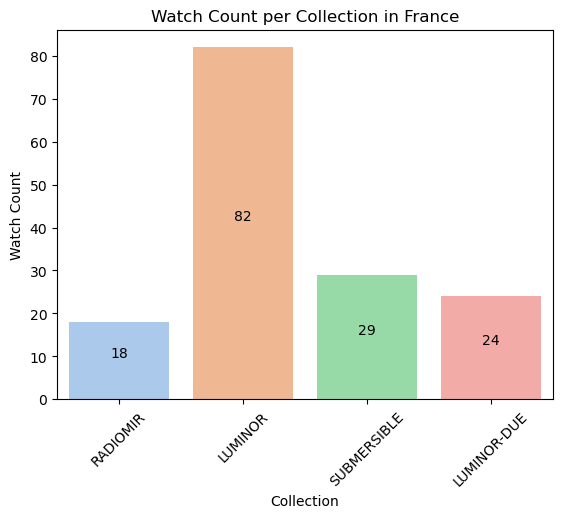

In [216]:
collection_visualization(data, country)

In [217]:
overall_stats, collection_stats = analyze_country(data, country)

#### Identify the cheapest and most expensive product in the whole subset

In [1]:
overall_stats, collection_stats = analyze_country(data, country)

print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")

NameError: name 'analyze_country' is not defined

#### Identify the cheapest and most expensive product per collection

In [219]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: RADIOMIR
  Cheapest -> Reference: PAM00753, Price: 4400.0 EUR
  Most Expensive -> Reference: PAM00997, Price: 12900.0 EUR

--------------------------------------------------

Collection: LUMINOR
  Cheapest -> Reference: PAM00774, Price: 4900.0 EUR
  Most Expensive -> Reference: PAM01060, Price: 166000.0 EUR

--------------------------------------------------

Collection: SUBMERSIBLE
  Cheapest -> Reference: PAM00973, Price: 8700.0 EUR
  Most Expensive -> Reference: PAM01108, Price: 190000.0 EUR

--------------------------------------------------

Collection: LUMINOR-DUE
  Cheapest -> Reference: PAM00755, Price: 6100.0 EUR
  Most Expensive -> Reference: PAM00741, Price: 21500.0 EUR

--------------------------------------------------



### 4.2.2. UK

In [220]:
country = "UK"

In [221]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 155

We have 4 collections, and LUMINOR is the leading one

Catalog of Collections:
1. RADIOMIR
2. LUMINOR
3. LUMINOR-DUE
4. SUBMERSIBLE

We have a Total of 155 distinct products, with PAM00233 leading the selection from LUMINOR collection


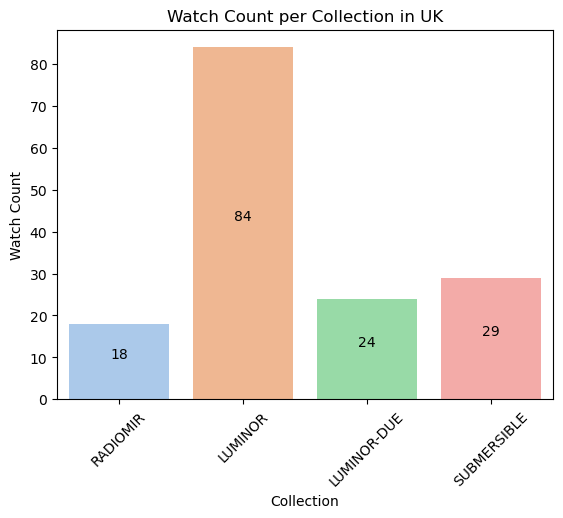

In [222]:
collection_visualization(data, country)

In [223]:
overall_stats, collection_stats = analyze_country(data, country)

In [224]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in UK:
  Cheapest -> Collection: RADIOMIR, Reference: PAM00753, Price: 3800.0 GBP
  Most Expensive -> Collection: SUBMERSIBLE, Reference: PAM01108, Price: 169900.0 GBP


In [225]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: RADIOMIR
  Cheapest -> Reference: PAM00753, Price: 3800.0 GBP
  Most Expensive -> Reference: PAM00997, Price: 11500.0 GBP

--------------------------------------------------

Collection: LUMINOR
  Cheapest -> Reference: PAM00774, Price: 4300.0 GBP
  Most Expensive -> Reference: PAM01060, Price: 148200.0 GBP

--------------------------------------------------

Collection: LUMINOR-DUE
  Cheapest -> Reference: PAM00755, Price: 5500.0 GBP
  Most Expensive -> Reference: PAM00675, Price: 22400.0 GBP

--------------------------------------------------

Collection: SUBMERSIBLE
  Cheapest -> Reference: PAM00973, Price: 7600.0 GBP
  Most Expensive -> Reference: PAM01108, Price: 169900.0 GBP

--------------------------------------------------



### 4.2.3. Japan

In [226]:
country = "Japan"

In [227]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 201

We have 4 collections, and LUMINOR is the leading one

Catalog of Collections:
1. RADIOMIR
2. LUMINOR
3. LUMINOR-DUE
4. SUBMERSIBLE

We have a Total of 201 distinct products, with PAM00233 leading the selection from LUMINOR collection


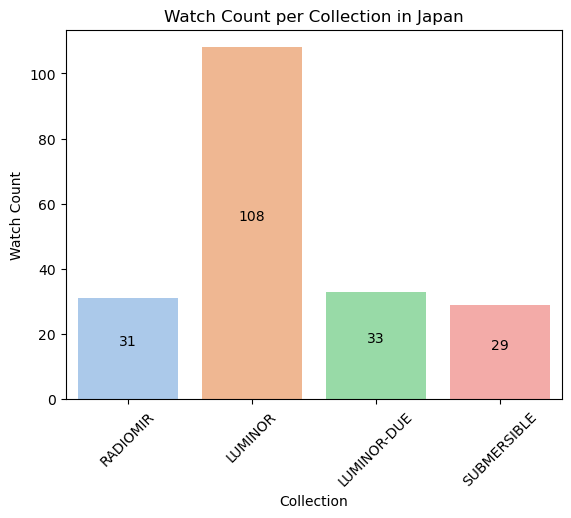

In [228]:
collection_visualization(data, country)

In [229]:
overall_stats, collection_stats = analyze_country(data, country)

In [230]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in Japan:
  Cheapest -> Collection: RADIOMIR, Reference: PAM00753, Price: 550000.0 JPY
  Most Expensive -> Collection: LUMINOR, Reference: PAM01060, Price: 20712000.0 JPY


In [231]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: RADIOMIR
  Cheapest -> Reference: PAM00753, Price: 550000.0 JPY
  Most Expensive -> Reference: PAM00515, Price: 2618000.0 JPY

--------------------------------------------------

Collection: LUMINOR
  Cheapest -> Reference: PAM00773, Price: 616000.0 JPY
  Most Expensive -> Reference: PAM01060, Price: 20712000.0 JPY

--------------------------------------------------

Collection: LUMINOR-DUE
  Cheapest -> Reference: PAM00755, Price: 748000.0 JPY
  Most Expensive -> Reference: PAM00675, Price: 3091000.0 JPY

--------------------------------------------------

Collection: SUBMERSIBLE
  Cheapest -> Reference: PAM00973, Price: 1078000.0 JPY
  Most Expensive -> Reference: PAM01225, Price: 7458000.0 JPY

--------------------------------------------------



### 4.2.4. USA

In [232]:
country = "USA"

In [233]:
number_rows, number_unique_collections, top_collection, number_unique_references, top_reference, collection_list = describe_country(data, country)

# Number of rows
print(f"Number of rows: {number_rows}")
if number_unique_collections == 1:
    print(f"\nThere is a unique collection, named {top_collection}")
else:
    print(f"\nWe have {number_unique_collections} collections, and {top_collection} is the leading one")

# Collections list    
print("\nCatalog of Collections:")
print("\n".join([f"{i+1}. {collection}" for i, collection in enumerate(collection_list)]))

# Distinct products based on Reference
if number_unique_references == 1:
    print(f"\nThere is a unique reference: {top_reference}")
else:
    print(f"\nWe have a Total of {number_unique_references} distinct products, with {top_reference} leading the selection from {data[data['reference'] == top_reference]['collection'].values[0]} collection")

Number of rows: 178

We have 4 collections, and LUMINOR is the leading one

Catalog of Collections:
1. RADIOMIR
2. LUMINOR
3. LUMINOR-DUE
4. SUBMERSIBLE

We have a Total of 178 distinct products, with PAM00233 leading the selection from LUMINOR collection


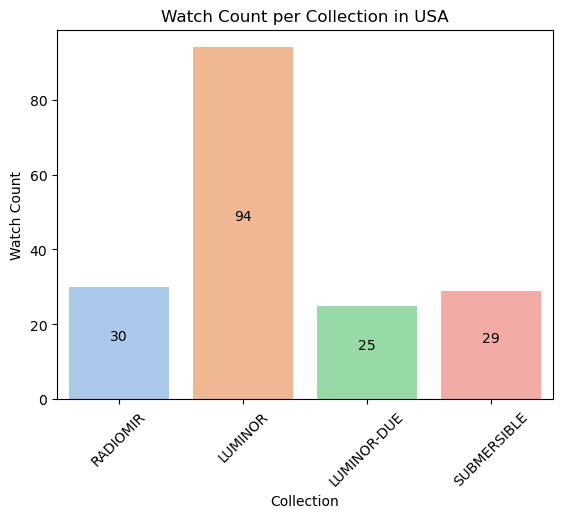

In [234]:
collection_visualization(data, country)

In [235]:
overall_stats, collection_stats = analyze_country(data, country)

In [236]:
print(f"\nCheapest and most expensive product in {country}:")
print(f"  Cheapest -> Collection: {overall_stats['cheapest']['collection']}, Reference: {overall_stats['cheapest']['reference']}, Price: {overall_stats['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
print(f"  Most Expensive -> Collection: {overall_stats['most_expensive']['collection']}, Reference: {overall_stats['most_expensive']['reference']}, Price: {overall_stats['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")


Cheapest and most expensive product in USA:
  Cheapest -> Collection: RADIOMIR, Reference: PAM00753, Price: 5700.0 USD
  Most Expensive -> Collection: SUBMERSIBLE, Reference: PAM01108, Price: 247700.0 USD


In [237]:
for stat in collection_stats:
    print(f"Collection: {stat['collection']}")
    print(f"  Cheapest -> Reference: {stat['cheapest']['reference']}, Price: {stat['cheapest']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print(f"  Most Expensive -> Reference: {stat['most_expensive']['reference']}, Price: {stat['most_expensive']['price']} {(data['currency'][data['country'] == country]).unique()[0]}")
    print("\n"+"-"*50+"\n")

Collection: RADIOMIR
  Cheapest -> Reference: PAM00753, Price: 5700.0 USD
  Most Expensive -> Reference: PAM00515, Price: 27200.0 USD

--------------------------------------------------

Collection: LUMINOR
  Cheapest -> Reference: PAM00773, Price: 6400.0 USD
  Most Expensive -> Reference: PAM01060, Price: 217000.0 USD

--------------------------------------------------

Collection: LUMINOR-DUE
  Cheapest -> Reference: PAM00755, Price: 8000.0 USD
  Most Expensive -> Reference: PAM00675, Price: 32100.0 USD

--------------------------------------------------

Collection: SUBMERSIBLE
  Cheapest -> Reference: PAM00973, Price: 11300.0 USD
  Most Expensive -> Reference: PAM01108, Price: 247700.0 USD

--------------------------------------------------

